In [47]:
# Imports 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV , KFold
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 

In [18]:
class DataSet:
    '''
    - This class is used to load data from the various .csv files and convert them to pd.DataFrame. 
    - Please feel free to load more .csv files here if you wish to use them. 
    - This class stores three data sets
        - training set: used to train the models (determine paramters)
        - dev set: used for cross validation (determine best hyper parameters)
        - test set: used to test the final model (determine performance)
        - ! PLEASE DO NOT USE THE TEST SET FOR ANYTHING OTHER THAN TESTING THE FINAL MODEL !
    - The init function currently:
        - loads training_files/trades.csv, training_files/stock_list.csv, training_files/stock_prices.csv and supplemental_files/stock_prices.csv
        - Takes the most recently 6 months of data from supplemental_files/stock_prices.csv as a validation set and the rest is addded to training/stock_prices.csv
        - splits the modified training_file/stock_prices.csv into a training set and a test set (defaults to 70% training, 30% test with seed = 42)
    - Any methods that returns data will return a pd.DataFrame.
    '''

    TRAINING_DIRECTORY = "train_files/"
    TEST_DIRECTORY = "example_test_files/"
    SUPPLEMENTAL_DIRECTORY = "supplemental_files/"
    
    def __init__(self, seed = 42, train_size = 0.70):
        self._trades = pd.read_csv(self.TRAINING_DIRECTORY + "trades.csv")
        self._stock_list = pd.read_csv("stock_list.csv")
        self.seed = seed
        
        prices_df = pd.read_csv(self.TRAINING_DIRECTORY + "stock_prices.csv").fillna(0)
        supp_prices_df = pd.read_csv(self.SUPPLEMENTAL_DIRECTORY + "stock_prices.csv").fillna(0)
        extra_training_df = supp_prices_df[supp_prices_df.Date < "2021-06-1"]
        
        self._stock_prices = pd.concat([prices_df, extra_training_df])
        
        X = self._stock_prices.drop(["Target", "RowId"], axis = 1)
        y = self._stock_prices["Target"]
        
        x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = train_size, random_state = seed)
        self.X_train = pd.DataFrame(x_train, columns = X.columns)
        self.Y_train = pd.DataFrame(y_train, columns = ["Target"])
       
        stock_prices_d = supp_prices_df[supp_prices_df.Date >= "2021-06-1"]
        self.X_dev = stock_prices_d.drop(["Target", "RowId"], axis = 1)
        self.X_dev.set_index(["Date", "SecuritiesCode"], inplace = True)
        self.Y_dev = stock_prices_d["Target"].to_frame()
       
        self.X_test = pd.DataFrame(x_test, columns = self._stock_prices.columns)
        self.Y_test = pd.DataFrame(y_test, columns = ["Target"])
        
    def stocks(self) -> np.ndarray:
        return self._stock_prices["SecuritiesCode"].unique()
      
    # def vwap(g):
    #     g['vwap'] = (g.tp * g.Volume).cumsum() / g.Volume.cumsum()
    #     return g

    #     df['tp'] = (df['Low'] + df['Close'] + df['High']) / 3
    #     df = df.groupby(df.Date.dt.date).apply(vwap)
    #     df
        
    def add_features(self):
        def _add_features(df: pd.DataFrame) -> pd.DataFrame:
            # def vwap(df):
            #     df["Vwap"] = (df["Adjusted"] * df["Volume"]).rolling(3).sum() / df["Volume"].rolling(3).sum()
            #     return df
            # df["Adjusted"] = (df['Low'] + df['High'] + df['Close']) / 3
            # x = df.groupby(["Date", "SecuritiesCode"]).apply(vwap)
            # print(x.head())
            # print(df.groupby(["SecuritiesCode", "Date"]).head())
                
                 
            
            # df["vwap_3_day"] = adjusted_price.div(df["Volume"].rolling(3).sum())
            # df["adjusted_price"] = adjusted_price
            print(df.head())
            
            return df
        
        # self.X_train = _add_features(self.X_train)
        self.X_dev = _add_features(self.X_dev)
        # self.X_test = _add_features(self.X_test)
        
    def x_train(self, security = None) -> pd.DataFrame:
        if security is not None:
            return self.X_train[self.X_train["SecuritiesCode"] == security]
        
        return self.X_train
        
    def x_test(self, security = None) -> pd.DataFrame:
        if security is not None:
            return self.X_test[self.X_test["SecuritiesCode"] == security]            

        return self.X_test
    
    def x_dev(self, security = None) -> pd.DataFrame:
        if security is not None:
            return self.X_dev[self.X_dev["SecuritiesCode"] == security]
        
        return self.X_dev
    
    def y_dev(self, security = None) -> pd.DataFrame:
        if security is not None:
            return self.Y_dev[self.Y_dev["SecuritiesCode"] == security]
        
        return self.Y_dev

    def y_train(self, security = None) -> pd.DataFrame:            
        if security is not None:
            return self.Y_train[self.Y_train["SecuritiesCode"] == security]   
        
        return self.Y_train  
            
    def y_test(self, security = None) -> pd.DataFrame:
        if security is not  None:
            return self.Y_test[self.X_test["SecuritiesCode"] == security]
        
        return self.Y_test
        
    def stock_list(self) -> pd.DataFrame:
        return self._stock_list
    
    def trades(self) -> pd.DataFrame:
        return self._trades
    
    def stock_prices(self) -> pd.DataFrame:
        return self._stock_prices
    
    def get_seed(self) -> int:
        return self.seed 
    
ds = DataSet()
ds.add_features()

                             Open    High     Low   Close   Volume  \
Date       SecuritiesCode                                            
2021-12-06 1301            2982.0  2982.0  2965.0  2971.0     8900   
           1332             592.0   599.0   588.0   589.0  1360800   
           1333            2368.0  2388.0  2360.0  2377.0   125900   
           1375            1230.0  1239.0  1224.0  1224.0    81100   
           1376            1339.0  1372.0  1339.0  1351.0     6200   

                           AdjustmentFactor  ExpectedDividend  SupervisionFlag  
Date       SecuritiesCode                                                       
2021-12-06 1301                         1.0               0.0            False  
           1332                         1.0               0.0            False  
           1333                         1.0               0.0            False  
           1375                         1.0               0.0            False  
           1376        

In [ ]:
def plot_stock_price(securities_code):
    df = ds.stock_prices()
    df[df["SecuritiesCode"] == securities_code].plot(x = "Date", y = "Close", figsize=(8,4))
    plt.ylabel("Close")
    plt.title("Close for {}".format(securities_code))
    plt.locator_params(axis='x', nbins=8)
    plt.show()

def plot_stock_target(securities_code):
    df = ds.stock_prices()
    df[df["SecuritiesCode"] == securities_code].plot(x = "Date", y = "Target", figsize=(8,4))
    plt.ylabel("Target")
    plt.title("Target for {}".format(securities_code))
    plt.locator_params(axis='x', nbins=8)
    plt.show()

plot_stock_price(6502)
plot_stock_target(6502)


In [ ]:
# Matt's Linear Models
class LinearModels:
    '''
    - This class is used to train and test various linear models such as LinearRegression, RidgeRegression and ElasticNet
    - The features used are those in the basic_features list.
    - For each model, the MSE is calculated and the predictions are plotted against the true target values from the test set.
    '''
    def __init__(self):
        self.features = [
            "Open",
            "High",
            "Low",
            "Close",
            "Volume",
            "AdjustmentFactor",
            "ExpectedDividend",
            "SupervisionFlag",
        ]
        self.ds = DataSet()
        
        self.lr_model = None
        self.rg_model = None
        self.en_model = None
        self.trained = False
    
    def get_linear_regression(self):
        if not self.trained:
            print("Please train the models first")
            return
        return self.lr_model
        
    def get_ridge_regression(self):
        if not self.trained:
            print("Please train the models first")
            return 
        return self.rg_model
    
    def get_features(self) -> list:
        return self.features
    
    def train(self):
        if self.trained:
            return 
    
        x_train = self.ds.x_train()[self.features]
        y_train = self.ds.y_train() 
        
        x_dev = self.ds.x_dev()[self.features]
        y_dev = self.ds.y_dev()
        
        cv_alpha = make_pipeline(
            StandardScaler(), 
            RidgeCV(alphas = np.logspace(-6, 6, 13))
        ).fit(x_dev, y_dev).named_steps['ridgecv'].alpha_
        
        print(f"The best alpha for Ridge Regression is {cv_alpha}")
        
        self.lr_model = make_pipeline(StandardScaler(), LinearRegression()).fit(x_train, y_train)
        self.rg_model = make_pipeline(StandardScaler(), Ridge(alpha = cv_alpha)).fit(x_train, y_train)
        self.en_model = make_pipeline(StandardScaler(), ElasticNet()).fit(x_train, y_train)
        
        self.trained = True 
        
    def compute_losses(self):
        if not self.trained:
            print("Please train the models first")
            return
    
        def compute_loss(model, model_name):
            x_test = self.ds.x_test()[self.features]
            y_test = self.ds.y_test()
            
            y_pred = model.predict(x_test)
            mse = float(mean_squared_error(y_test, y_pred))
            
            plt.scatter(y_test, y_pred)
            plt.xlabel("True Target")
            plt.ylabel("Predicted Target")
            plt.title(f"Predictions for {model_name} (MSE: {mse})")
            plt.axis('equal')
            plt.show()
            
            print("MSE for {} is {}".format(model_name, mse))

        compute_loss(self.lr_model, "Linear Regression")
        compute_loss(self.rg_model, "Ridge Regression")
        compute_loss(self.en_model, "Elastic Net")
            
lm = LinearModels()
lm.train()
lm.compute_losses()

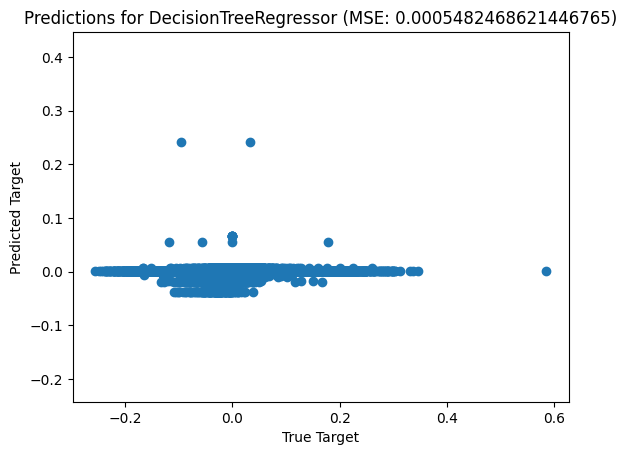

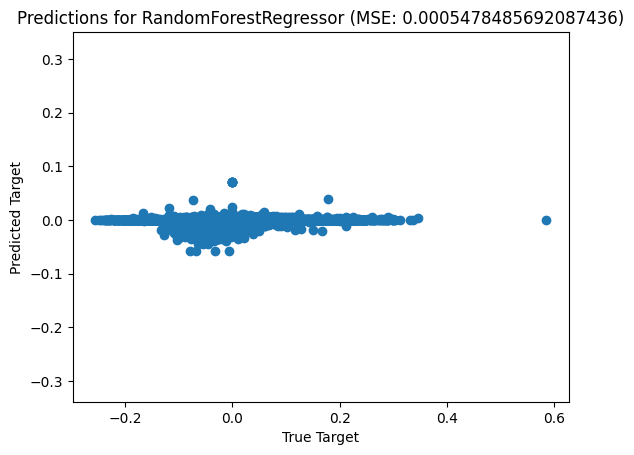

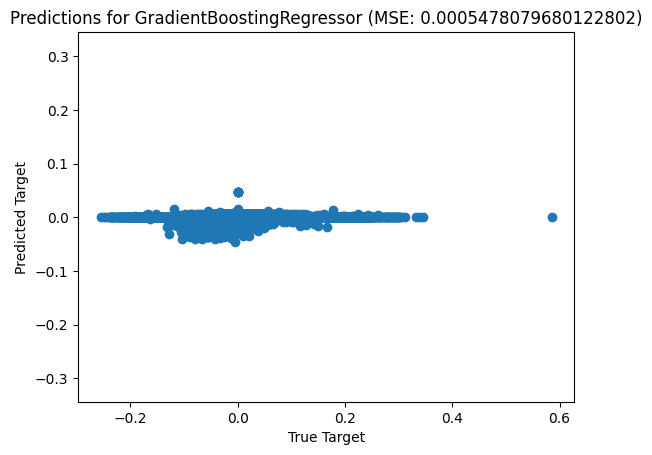

<Figure size 640x480 with 0 Axes>

In [20]:
# Matt's Tree Models (with Ensembles)
class TreeMethods:
    def __init__(self, max_depth = 20):
        self.ds = DataSet()
        self.max_depth = max_depth
        
        self.dt = DecisionTreeRegressor()               # decision tree  
        self.dt_optimal_depth = 4                       # ! reset to None when using a new dev set
        
        self.rf = RandomForestRegressor()               # random forest
        self.rf_optimal_params = {                      # ! reset to None when using a new dev set
            'max_depth': 6, 
            'max_features': 4, 
            'n_estimators': 50
        }
        
        self.gb = GradientBoostingRegressor()           # gradient boosting 
        self.gb_optimal_params = {                      # ! reset to None when using a new dev set
            'learning_rate': 0.1, 
            'max_depth': 3, 
            'n_estimators': 35
        }
        
        self.features = [
            "Open",
            "High",
            "Low",
            "Close",
            "Volume",
            "AdjustmentFactor",
            "ExpectedDividend",
            "SupervisionFlag",
        ]
        
        self.rf_param_grid = {
            'max_depth': range(2, self.max_depth, 2),
            'max_features': range(2, len(self.features)),
            'n_estimators': [ 5, 10, 20, 35, 50 ]
        }
        self.gb_param_grid = {
            'max_depth': range(2, int(self.max_depth / 2)),
            'learning_rate': [ 0.01, 0.05, 0.1, 0.2 ],
            'n_estimators': [ 5, 10, 20, 35, 50 ]
        }
        self.trained = False 
        
    def get_models(self) -> tuple:
        return (self.dt, self.rf, self.gb)
    
    def get_features(self) -> list:
        return self.features
    
    def _dt_cross_validation(self):
        x_train = self.ds.x_train()[self.features]
        y_train = self.ds.y_train()
        x_dev = self.ds.x_dev()[self.features]
        y_dev = self.ds.y_dev()
        score = 0
        best_depth = 2
        for depth in range(2, self.max_depth):
            dtr = DecisionTreeRegressor(max_depth = depth)
            dtr.fit(x_train, y_train)
            
            # using r-squared as the metric for determining the best depth because it measures best fit
            dev_score = dtr.score(x_dev, y_dev)
            if dev_score > score:
                score = dev_score
                best_depth = depth
        print(f"Best depth is for Decision Tree is {self.dt_optimal_depth}")   
        return best_depth
            
    def _rf_cross_validation(self):
        x_dev = self.ds.x_dev()[self.features]
        y_dev = self.ds.y_dev()
        grid_search = GridSearchCV(
            estimator = RandomForestRegressor(random_state = ds.get_seed()),
            param_grid = self.rf_param_grid,
            cv = KFold(n_splits = 5, shuffle = True, random_state = ds.get_seed() + 1))
        grid_search.fit(x_dev, y_dev.values.ravel())
        print(f"Best parameters for Random Forest are {self.rf_optimal_params}")
        return grid_search.best_params_
    
    def _gb_cross_validation(self):
        x_dev = self.ds.x_dev()[self.features]
        y_dev = self.ds.y_dev()
        grid_search = GridSearchCV(
            estimator = GradientBoostingRegressor(random_state = ds.get_seed()),
            param_grid = self.gb_param_grid,
            cv = KFold(n_splits = 5, shuffle = True, random_state = ds.get_seed() + 1))
        grid_search.fit(x_dev, y_dev.values.ravel())
        print(f"Best parameters for Gradient Boosting are {self.gb_optimal_params}")
        return grid_search.best_params_
    
    def train(self):
        if self.trained:
            return 
        x_train = self.ds.x_train()[self.features]
        y_train = self.ds.y_train()
        seed = ds.get_seed()
        
        if self.dt_optimal_depth is None:
            self.dt_optimal_depth = self._dt_cross_validation() 
            
        self.dt = DecisionTreeRegressor(max_depth = self.dt_optimal_depth).fit(x_train, y_train)
        
        if self.rf_optimal_params is None:
            self.rf_params = self._rf_cross_validation()
        
        self.rf = RandomForestRegressor(
            n_estimators = self.rf_optimal_params["n_estimators"], 
            max_features = self.rf_optimal_params["max_features"],
            max_depth = self.rf_optimal_params["max_depth"],
            random_state = seed)
        self.rf.fit(x_train, y_train.values.ravel())
        
        if self.gb_optimal_params is None:    
            self.gb_optimal_params = self._gb_cross_validation()        
            
        self.gb = GradientBoostingRegressor(
            n_estimators = self.gb_optimal_params["n_estimators"],
            max_depth = self.gb_optimal_params["max_depth"],
            learning_rate = self.gb_optimal_params["learning_rate"], 
            random_state = seed)
        self.gb.fit(x_train, y_train.values.ravel())
        
        self.trained = True 
        
    def compute_losses(self):
        if not self.trained:
            print("Please train the models first")
            return
        
        x_test = self.ds.x_test()[self.features]
        y_test = self.ds.y_test()
        
        def compute_loss(model, model_name):
            y_pred = model.predict(x_test)
            mse = float(mean_squared_error(y_test, y_pred))
        
            plt.scatter(y_test, y_pred)
            plt.xlabel("True Target")
            plt.ylabel("Predicted Target")
            plt.title(f"Predictions for {model_name} (MSE: {mse})")
            plt.axis('equal')
            plt.show()
            plt.savefig(f"plots/{model_name}.png")
        
        compute_loss(self.dt, "DecisionTreeRegressor")
        compute_loss(self.rf, "RandomForestRegressor")
        compute_loss(self.gb, "GradientBoostingRegressor")
        
tm = TreeMethods()
tm.train()
tm.compute_losses()

In [ ]:
# Matt's Ensemble Litrature Findings
'''
    [Mehta S, Rana P, Singh S, Sharma A, Agarwal P. Ensemble learning approach for enhanced stock prediction.]
        Their results show that the ensemble learning technique attained maximum accuracy with lesser variance in stock prediction.
        
    [Kohli PPS, Zargar S, Arora S, Gupta P. Stock prediction using machine learning algorithms.]
        Kohli et al. [46] examined different ML algorithms (SVM, RF, Gradient Boosting and AdaBoost) performance in stock market price prediction. 
        The study showed that AdaBoost outperformed Gradient Boosting in terms of predicting accuracy.
    
    [Ren Y, Suganthan PN, Srikanth N. Ensemble methods for wind and solar power forecasting—a state-of-the-art review.]
        Thus, EMs highlights the strong point and watered-down the feebleness of the single classifiers. 
'''

In [45]:
# Competition

import warnings 
warnings.filterwarnings("ignore")

# Code supplied by competition host
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)        # type: ignore
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

def check_score(X, model, features):
    '''
    Args:
        X: DataFrame containing the features of the test set you wish to use
        model: model you wish to use to make the prediction
        features: features you used to train the model
    Effect:
        prints the sharpe ratio (score) of the metric on the test set
    '''
    
    def add_rank(df: pd.DataFrame) -> pd.DataFrame:
        df["Rank"] = df.groupby("Date")["Target"].rank(ascending = False, method = "first") - 1
        df["Rank"] = df["Rank"].astype("int")
        return df
    
    predicted_targets = model.predict(X[features])
    submission = pd.DataFrame(X[["Date", "SecuritiesCode"]])
    submission["Target"] = predicted_targets
    submission = add_rank(submission)
    score = round(calc_spread_return_sharpe(submission), 5)
    
    print(f"Score: {score}")

lr = lm.get_linear_regression()
check_score(ds.x_test(), lr, lm.get_features())

gb = tm.get_models()[2]
check_score(ds.x_test(), gb, tm.get_features())



Score: 0.34809
Score: 0.40369
